Информация о наборе данных:

Этот архив содержит 2075259 измерений, выполненных в период с декабря 2006 по ноябрь 2010 года (47 месяцев).
Записи:
1.(global_active_power*1000/60 - sub_metering_1 - sub_metering_2 - sub_metering_3) представляет собой активную энергию, потребляемую ежеминутно (в ватт-часах) в домашнем хозяйстве электрическим оборудованием, не указанным в подпунктах 1, 2 и 3.

2.Набор данных содержит некоторые пропущенные значения в измерениях (почти 1,25% строк). Все календарные временные метки присутствуют в наборе данных, но для некоторых временных меток значения измерений отсутствуют: пропущенное значение представлено отсутствием значения между двумя последовательными разделителями атрибутов с запятой. Например, в наборе данных отсутствуют значения на 28 апреля 2007 года.

Информация об атрибуте:
1.дата: Дата в формате дд/мм/гггг

2.время: время в формате чч:мм:сс

3.global_active_power: глобальная усредненная за минуту активная мощность домохозяйства (в киловаттах)

4.global_reactive_power: глобальная, усредненная за минуту реактивная мощность домохозяйства (в киловаттах)

5.voltage: усредненное за минуту напряжение (в вольтах)

6.global_intensity: глобальная, усредненная за минуту сила тока домохозяйства (в амперах)

7.подсчет_1: подсчет энергии № 1 (в ватт-часах активной энергии). Он соответствует кухне, на которой в основном установлены посудомоечная машина, духовка и микроволновая печь (плиты не электрические, а газовые).

8.подсчет_2: подсчет энергии № 2 (в ватт-часах активной энергии). Это соответствует помещению для стирки, в котором есть стиральная машина, сушилка для белья, холодильник и освещение.

9.подсчет_3: подсчет энергии № 3 (в ватт-часах активной энергии). Соответствует электрическому водонагревателю и кондиционеру.

In [61]:
import sys, os, warnings, math, random

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

import optuna
from optuna.samplers import TPESampler

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import joblib
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Фиксация сидов
SEED = 42


def set_seeds(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


set_seeds()

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [62]:
# Загрузка данных
df = pd.read_csv(
    "household_power_consumption.txt",
    delimiter=";",
)

df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [63]:
# Преобразование объектов для лучшего анализа
df["datetime"] = pd.to_datetime(df["Date"] + " " + df["Time"])
df["Global_active_power"] = pd.to_numeric(df["Global_active_power"], errors="coerce")
df = df.dropna(subset=["Global_active_power"])

df["datetime"] = pd.to_datetime(df["datetime"])
df = df.loc[:, ["datetime", "Global_active_power"]]
df.sort_values("datetime", inplace=True, ascending=True)
df = df.reset_index(drop=True)

In [64]:
df["year"] = df["datetime"].apply(lambda x: x.year)
df["quarter"] = df["datetime"].apply(lambda x: x.quarter)
df["month"] = df["datetime"].apply(lambda x: x.month)
df["day"] = df["datetime"].apply(lambda x: x.day)
df = df.loc[:, ["datetime", "Global_active_power", "year", "quarter", "month", "day"]]
df.sort_values("datetime", inplace=True, ascending=True)
df = df.reset_index(drop=True)
df["weekday"] = df.apply(lambda row: row["datetime"].weekday(), axis=1)
df["weekday"] = (df["weekday"] < 5).astype(int)


print("Количество строк и столбцов после удаления пропущенных значений:", df.shape)
print("Временной ряд начинается с:", df["datetime"].min())
print("Временной ряд заканчивается на:", df["datetime"].max())

Количество строк и столбцов после удаления пропущенных значений: (2049280, 7)
Временной ряд начинается с: 2006-12-16 17:24:00
Временной ряд заканчивается на: 2010-11-26 21:02:00


In [66]:
# Проверка, соответствуют ли данные нормальному распределению или нет
stat, p = stats.normaltest(df.Global_active_power)
print("Statistics=%.3f, p=%.6f" % (stat, p))
alpha = 0.05
if p > alpha:
    print("Данные выглядят по Гауссу (не удается отклонить H0)")
else:
    print("Данные не выглядят гауссовскими (отклонение H0)")

Statistics=724881.795, p=0.000000
Данные не выглядят гауссовскими (отклонение H0)


In [67]:
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2049280 entries, 0 to 2049279
Data columns (total 7 columns):
 #   Column               Dtype         
---  ------               -----         
 0   datetime             datetime64[ns]
 1   Global_active_power  float64       
 2   year                 int64         
 3   quarter              int64         
 4   month                int64         
 5   day                  int64         
 6   weekday              int64         
dtypes: datetime64[ns](1), float64(1), int64(5)
memory usage: 109.4 MB


,datetime,Global_active_power,year,quarter,month,day,weekday
0,2006-12-16 17:24:00,4.216,2006,4,12,16,0
1,2006-12-16 17:25:00,5.360,2006,4,12,16,0
2,2006-12-16 17:26:00,5.374,2006,4,12,16,0
3,2006-12-16 17:27:00,5.388,2006,4,12,16,0
4,2006-12-16 17:28:00,3.666,2006,4,12,16,0
5,2006-12-16 17:29:00,3.520,2006,4,12,16,0
6,2006-12-16 17:30:00,3.702,2006,4,12,16,0
7,2006-12-16 17:31:00,3.700,2006,4,12,16,0
8,2006-12-16 17:32:00,3.668,2006,4,12,16,0
9,2006-12-16 17:33:00,3.662,2006,4,12,16,0


Нарушение нормального распределения: 4.218671866132125
Асимметрия нормального распределения: 1.786232084632083


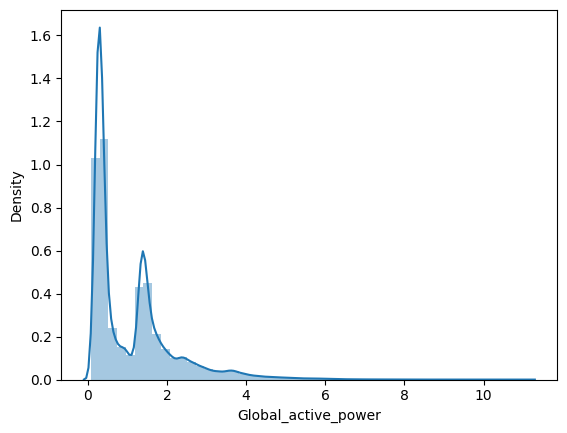

In [68]:
# Проверяем нарушение и асимметрию нормального распределения
sns.distplot(df.Global_active_power)

print(
    "Нарушение нормального распределения: {}".format(
        stats.kurtosis(df.Global_active_power)
    )
)
print(
    "Асимметрия нормального распределения: {}".format(
        stats.skew(df.Global_active_power)
    )
)

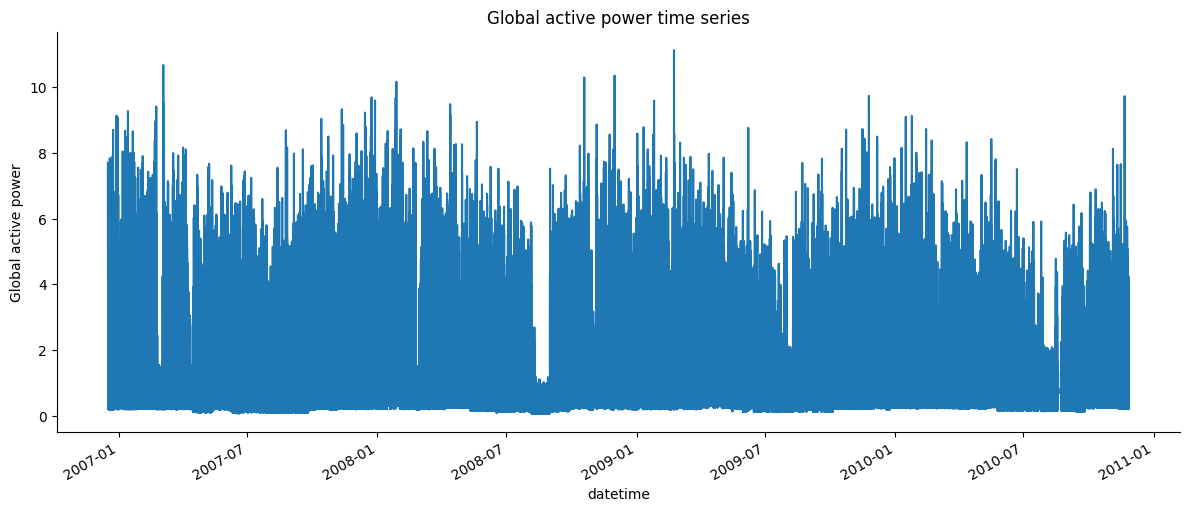

In [69]:
# Рисуем график временных рядов
df1 = df.loc[:, ["datetime", "Global_active_power"]]
df1.set_index("datetime", inplace=True)
df1.plot(figsize=(12, 5))
plt.ylabel("Global active power")
plt.legend().set_visible(False)
plt.tight_layout()
plt.title("Global active power time series")
sns.despine(top=True)
plt.show()

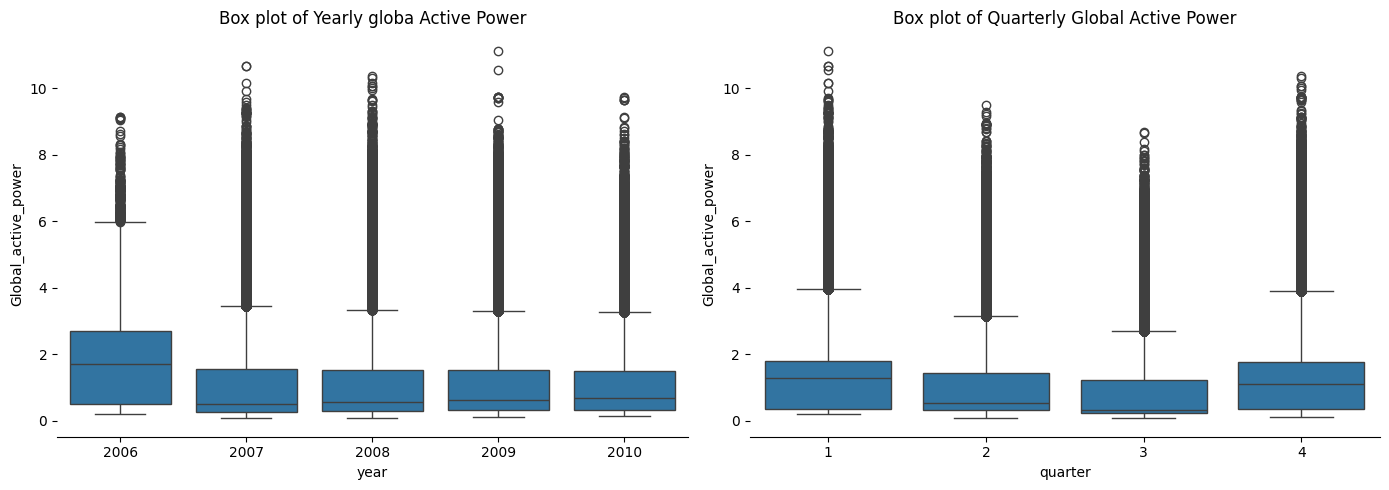

In [70]:
# Box plot of yearly vs quartly global active power
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.subplots_adjust(wspace=0.2)
sns.boxplot(x="year", y="Global_active_power", data=df)
plt.xlabel("year")
plt.title("Box plot of Yearly globa Active Power")
sns.despine(left=True)
plt.tight_layout()

plt.subplot(1, 2, 2)
sns.boxplot(x="quarter", y="Global_active_power", data=df)
plt.xlabel("quarter")
plt.title("Box plot of Quarterly Global Active Power")
sns.despine(left=True)
plt.tight_layout()

,count,mean,std,min,25%,50%,75%,max
Global_active_power,2049280.0,1.091615,1.057294,0.076,0.308,0.602,1.528,11.122


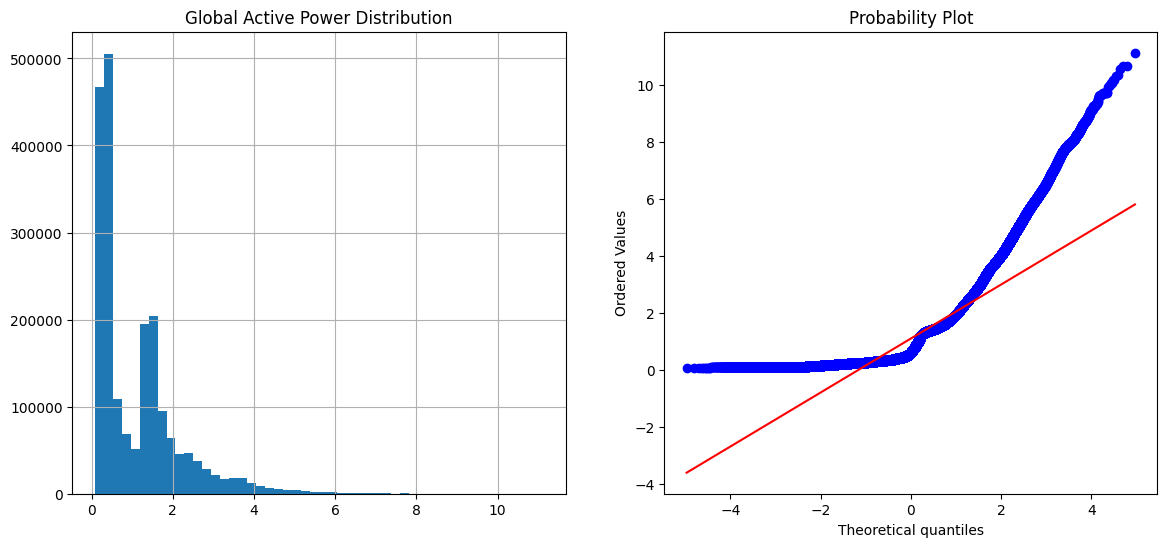

In [71]:
# Check the distribution
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
df["Global_active_power"].hist(bins=50)
plt.title("Global Active Power Distribution")

plt.subplot(1, 2, 2)
stats.probplot(df["Global_active_power"], plot=plt)
df1.describe().T

Text(0.5, 1.0, 'Средняя Global_active_power, пересчитанная за год')

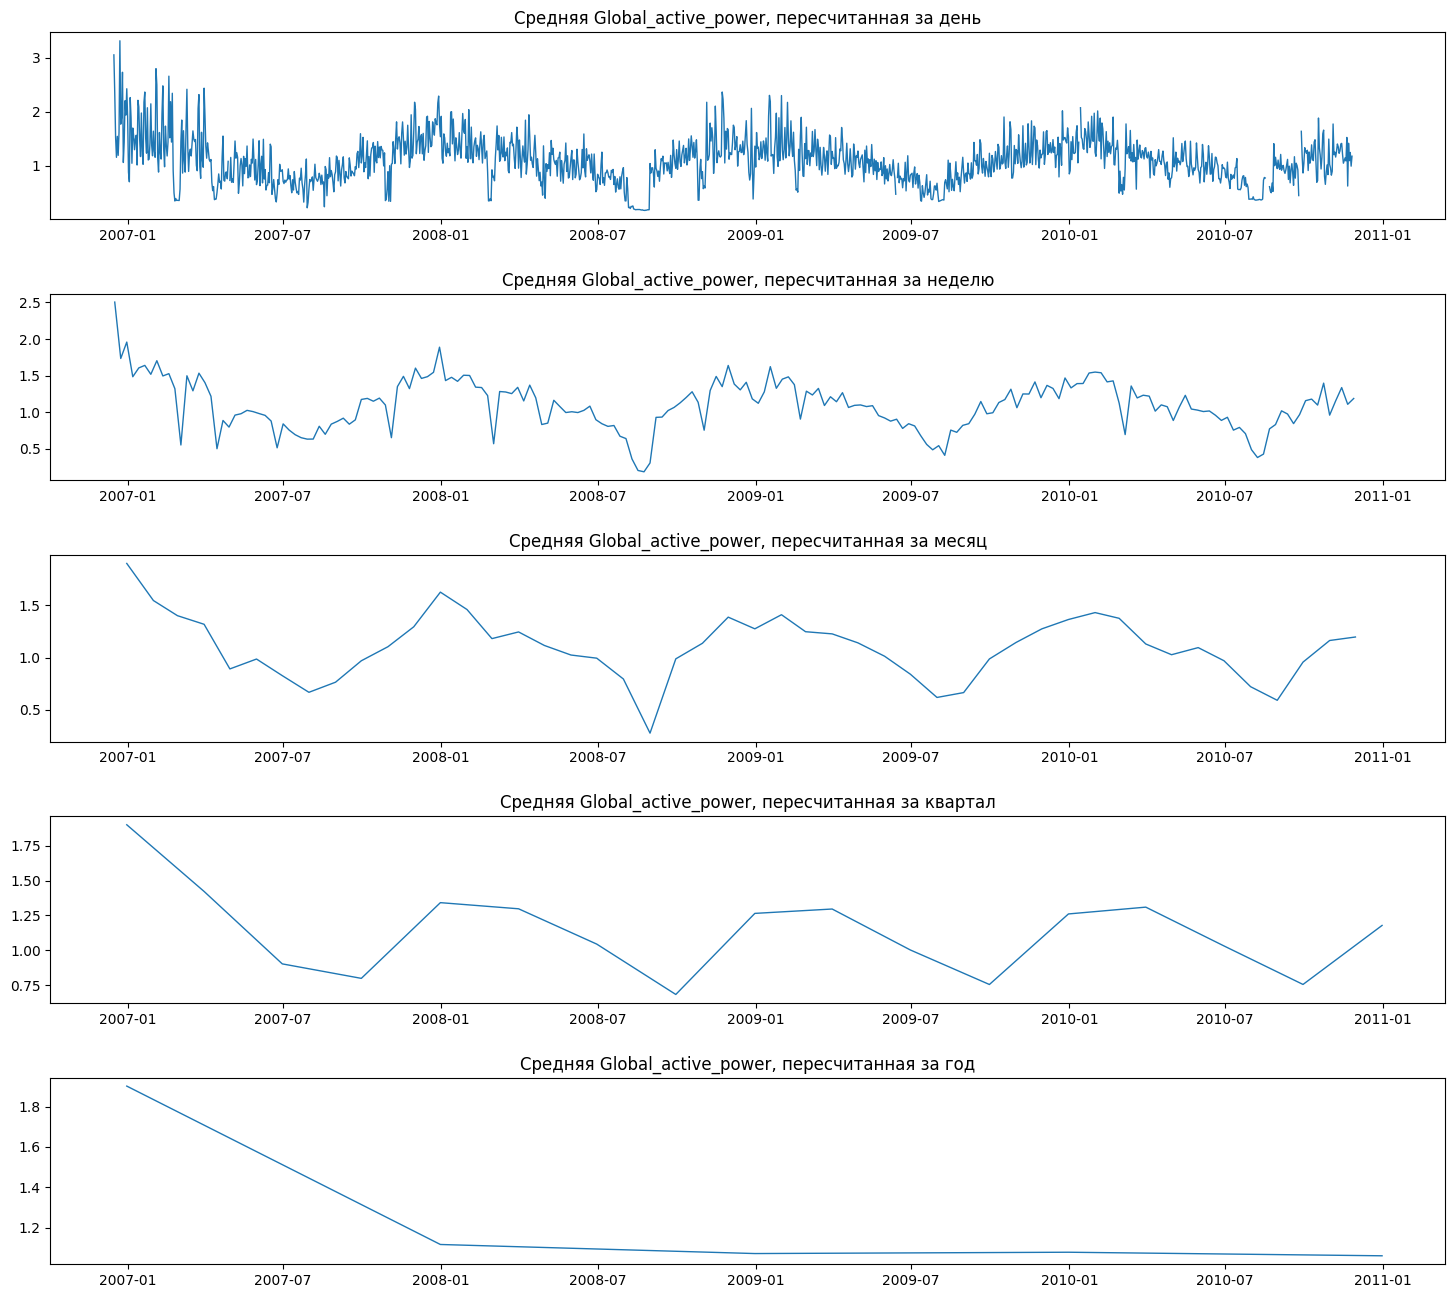

In [80]:
# График средней global active power, пересчитанной за день, неделю, месяц, квартал и год
fig = plt.figure(figsize=(18, 16))
fig.subplots_adjust(hspace=0.4)
ax1 = fig.add_subplot(5, 1, 1)
ax1.plot(df1["Global_active_power"].resample("D").mean(), linewidth=1)
ax1.set_title("Средняя Global_active_power, пересчитанная за день")
# ax1.tick_params(axis="both", which="major")

ax2 = fig.add_subplot(5, 1, 2, sharex=ax1)
ax2.plot(df1["Global_active_power"].resample("W").mean(), linewidth=1)
ax2.set_title("Средняя Global_active_power, пересчитанная за неделю")
# ax2.tick_params(axis="both", width="major")

ax3 = fig.add_subplot(5, 1, 3, sharex=ax1)
ax3.plot(df1["Global_active_power"].resample("M").mean(), linewidth=1)
ax3.set_title("Средняя Global_active_power, пересчитанная за месяц")
# ax3.tick_params(axis="both", which="major")

ax4 = fig.add_subplot(5, 1, 4, sharex=ax1)
ax4.plot(df1["Global_active_power"].resample("Q").mean(), linewidth=1)
ax4.set_title("Средняя Global_active_power, пересчитанная за квартал")
# ax4.tick_params(axis="both", which="major")

ax5 = fig.add_subplot(5, 1, 5, sharex=ax1)
ax5.plot(df1["Global_active_power"].resample("A").mean(), linewidth=1)
ax5.set_title("Средняя Global_active_power, пересчитанная за год")
# ax5.tick_params(axis="both", which="major")

Text(0.5, 1.0, 'Средняя гGlobal_active_power в сутки')

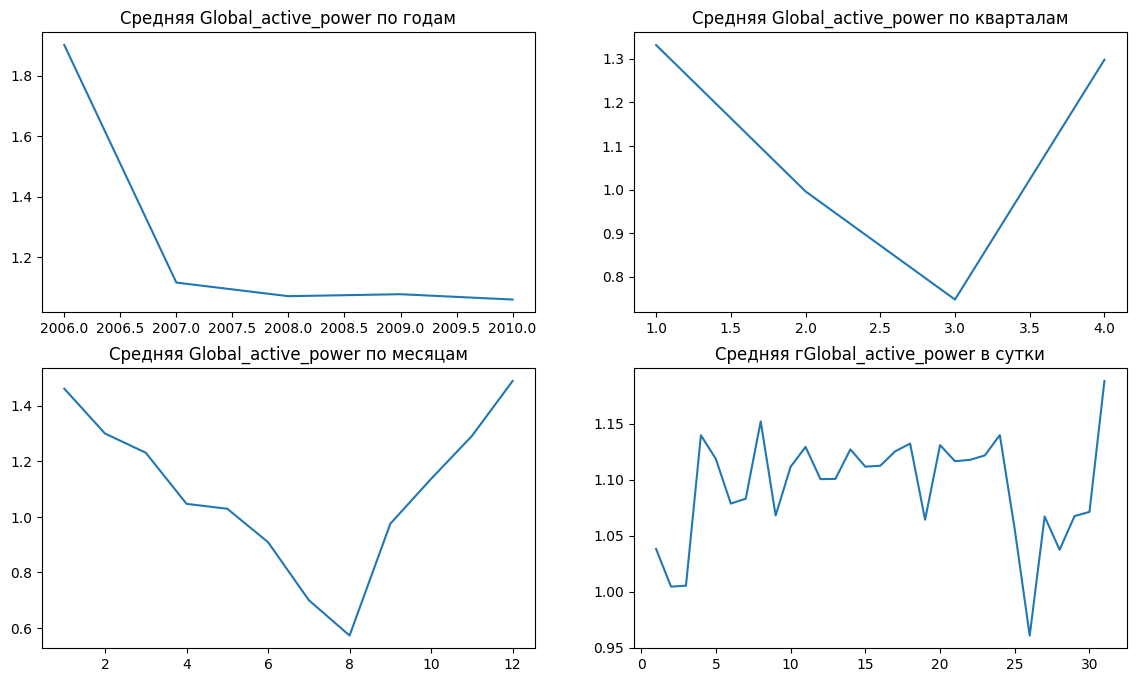

In [82]:
# График средней global active power, сгруппированной по годам, кварталам, месяцам и дням

plt.figure(figsize=(14, 8))
plt.subplot(2, 2, 1)
df.groupby("year").Global_active_power.agg("mean").plot()
plt.xlabel("")
plt.title("Средняя Global_active_power по годам")

plt.subplot(2, 2, 2)
df.groupby("quarter").Global_active_power.agg("mean").plot()
plt.xlabel("")
plt.title("Средняя Global_active_power по кварталам")

plt.subplot(2, 2, 3)
df.groupby("month").Global_active_power.agg("mean").plot()
plt.xlabel("")
plt.title("Средняя Global_active_power по месяцам")

plt.subplot(2, 2, 4)
df.groupby("day").Global_active_power.agg("mean").plot()
plt.xlabel("")
plt.title("Средняя гGlobal_active_power в сутки")

array([[<Axes: xlabel='month'>, <Axes: xlabel='month'>,
        <Axes: xlabel='month'>, <Axes: xlabel='month'>,
        <Axes: xlabel='month'>],
       [<Axes: xlabel='month'>, <Axes: xlabel='month'>,
        <Axes: xlabel='month'>, <Axes: xlabel='month'>,
        <Axes: xlabel='month'>],
       [<Axes: xlabel='month'>, <Axes: xlabel='month'>,
        <Axes: xlabel='month'>, <Axes: xlabel='month'>,
        <Axes: xlabel='month'>]], dtype=object)

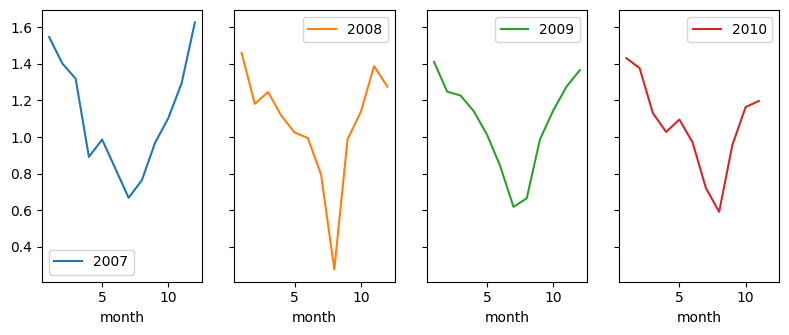

In [83]:
# Мы удаляем 2006 год, потому что другие годы имеют схожую структуру.
pd.pivot_table(
    df.loc[df["year"] != 2006],
    values="Global_active_power",
    columns="year",
    index="month",
).plot(subplots=True, figsize=(12, 12), layout=(3, 5), sharey=True)

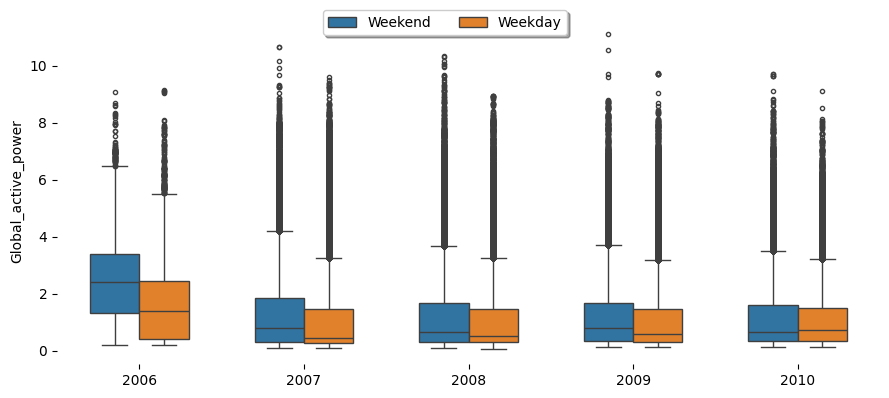

In [87]:
# Проверяем, как меняется энергопотребление в будние и выходные дни

dic = {0: "Weekend", 1: "Weekday"}
df["Day"] = df.weekday.map(dic)

a = plt.figure(figsize=(9, 4))
plt1 = sns.boxplot(
    x="year", y="Global_active_power", hue="Day", width=0.6, fliersize=3, data=df
)
a.legend(loc="upper center", bbox_to_anchor=(0.5, 1.0), shadow=True, ncol=2)

sns.despine(left=True, bottom=True)
plt.xlabel("")
plt.tight_layout()
plt.legend().set_visible(False)

In [88]:
df.head()

,datetime,Global_active_power,year,quarter,month,day,weekday,Day
0,2006-12-16 17:24:00,4.216,2006,4,12,16,0,Weekend
1,2006-12-16 17:25:00,5.360,2006,4,12,16,0,Weekend
2,2006-12-16 17:26:00,5.374,2006,4,12,16,0,Weekend
3,2006-12-16 17:27:00,5.388,2006,4,12,16,0,Weekend
4,2006-12-16 17:28:00,3.666,2006,4,12,16,0,Weekend


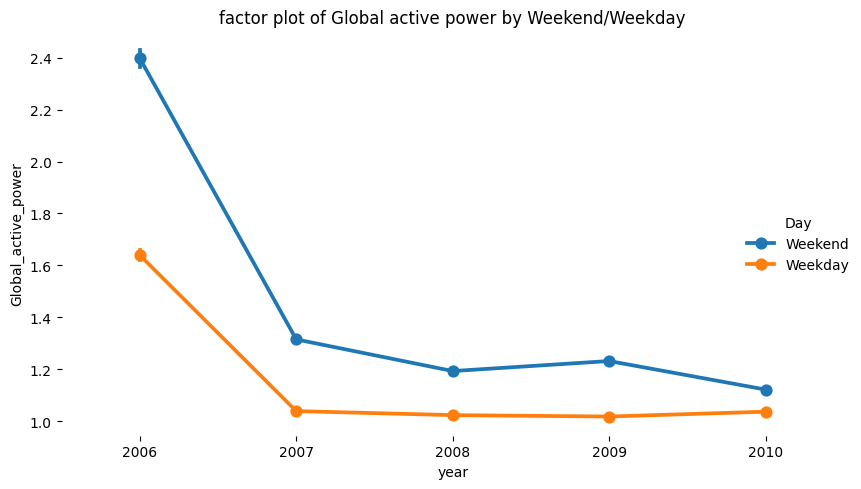

In [90]:
# График global active power в разбивке по дням недели и выходным
plt1 = sns.catplot(
    x="year",
    y="Global_active_power",
    hue="Day",
    data=df,
    aspect=1.5,
    # legend=False,
    kind="point",
)

plt.title("factor plot of Global active power by Weekend/Weekday")
plt.tight_layout()
sns.despine(left=True, bottom=True)

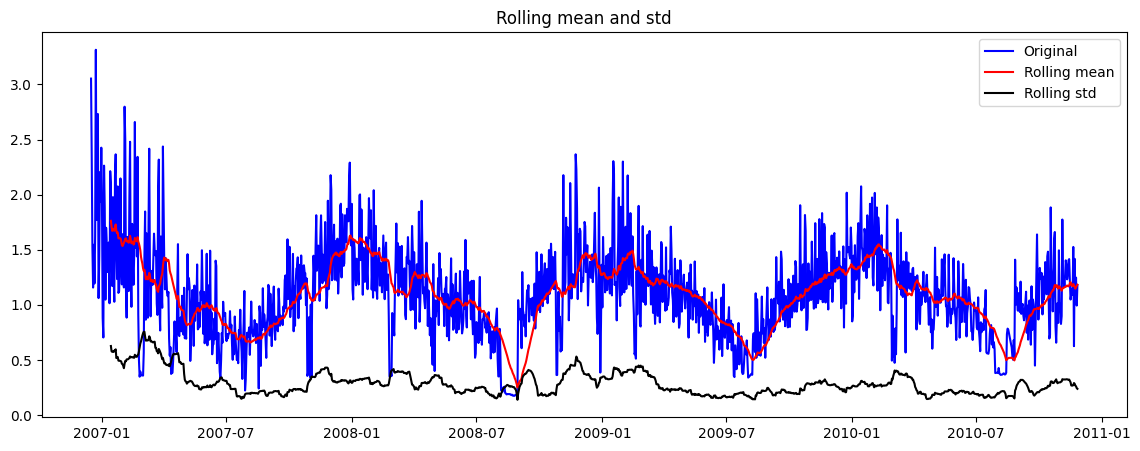

<Results of Dickey Fuller Test>
Test stastic                     -3.684228
p-value                           0.004341
#Lags Used                       22.000000
Number of observations used    1410.000000
Critical Value (1%)              -3.434996
Critical Value (5%)              -2.863592
Critical Value (10%)             -2.567862
dtype: float64


In [91]:
df2 = df1.resample("D").mean()


def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()

    plt.figure(figsize=(14, 5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color="blue", label="Original")
    mean = plt.plot(rolmean, color="red", label="Rolling mean")
    std = plt.plot(rolstd, color="black", label="Rolling std")

    plt.legend(loc="best")
    plt.title("Rolling mean and std")
    plt.show()

    print("<Results of Dickey Fuller Test>")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=["Test stastic", "p-value", "#Lags Used", "Number of observations used"],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)


test_stationarity(df2.Global_active_power.dropna())

In [101]:
# Используем LSTM-модель для прогнозирования
# Преобразовываем все данные в float
# Нормализуем параметр
# Преобразуем массив в матрицу
# Преобразуем в x = t и y = t + 1
# Преобразуем входные данные в 3D (samples, timesteps, features)

dataset = df.Global_active_power.values
dataset = dataset.astype("float32")
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size : len(dataset), :]


def create_dataset(dataset, look_back=1):
    x, y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i : (i + look_back), 0]
        x.append(a)
        y.append(dataset[i + look_back, 0])
    return np.array(x), np.array(y)


look_back = 30

x_train, y_train = create_dataset(train, look_back)
x_test, y_test = create_dataset(test, look_back)

# Reshape inputs
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

In [104]:
import tensorflow as tf
import warnings

warnings.filterwarnings("ignore")
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller

from keras.layers import *
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

# Train the model
model = tf.keras.Sequential()
model.add(LSTM(100, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(32))
model.add(Dense(16))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")

history = model.fit(
    x_train,
    y_train,
    epochs=20,
    batch_size=70,
    validation_data=(x_test, y_test),
    callbacks=[EarlyStopping(monitor="val_loss", patience=10)],
    verbose=1,
    shuffle=False,
)
model.summary()

Epoch 1/20
23420/23420 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - loss: 8.1313e-04 - val_loss: 4.0057e-04
Epoch 2/20
23420/23420 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - loss: 6.7906e-04 - val_loss: 4.0303e-04
Epoch 3/20
23420/23420 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - loss: 6.5292e-04 - val_loss: 4.0461e-04
Epoch 4/20
23420/23420 ━━━━━━━━━━━━━━━━━━━━ 44s 2ms/step - loss: 6.4508e-04 - val_loss: 4.0350e-04
Epoch 5/20
23420/23420 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step - loss: 6.3640e-04 - val_loss: 4.0455e-04
Epoch 6/20
23420/23420 ━━━━━━━━━━━━━━━━━━━━ 47s 2ms/step - loss: 6.3360e-04 - val_loss: 3.9732e-04
Epoch 7/20
23420/23420 ━━━━━━━━━━━━━━━━━━━━ 45s 2ms/step - loss: 6.3164e-04 - val_loss: 3.9324e-04
Epoch 8/20
23420/23420 ━━━━━━━━━━━━━━━━━━━━ 44s 2ms/step - loss: 6.2992e-04 - val_loss: 4.0130e-04
Epoch 9/20
23420/23420 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step - loss: 6.3052e-04 - val_loss: 3.9344e-04
Epoch 10/20
23420/23420 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - loss: 6.2842e-04 - val_loss: 3.9706e-04
Epoch 11/

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100)            │        52,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         3,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 168,533 (658.34 KB)

 Trainable params: 56,177 (219.44 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 112,356 (438.89 KB)

In [105]:
# Делаем предсказание

train_predict = model.predict(x_train)
test_predict = model.predict(x_test)
# инвертируем предскахзания
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])
print(
    "Train Mean Absolute Error:", mean_absolute_error(y_train[0], train_predict[:, 0])
)
print(
    "Train Root Mean Squared Error:",
    np.sqrt(mean_squared_error(y_train[0], train_predict[:, 0])),
)
print("Test Mean Absolute Error:", mean_absolute_error(y_test[0], test_predict[:, 0]))
print(
    "Test Root Mean Squared Error:",
    np.sqrt(mean_squared_error(y_test[0], test_predict[:, 0])),
)

51232/51232 ━━━━━━━━━━━━━━━━━━━━ 33s 646us/step
12808/12808 ━━━━━━━━━━━━━━━━━━━━ 9s 712us/step
Train Mean Absolute Error: 0.09245969114613162
Train Root Mean Squared Error: 0.2673237217360963
Test Mean Absolute Error: 0.07685755975834248
Test Root Mean Squared Error: 0.21779529579595516


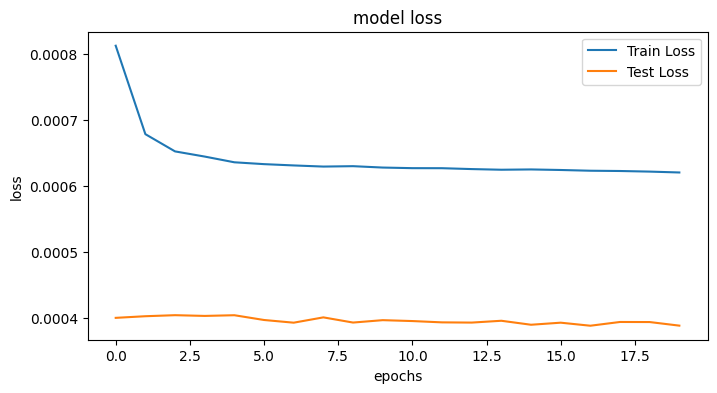

In [106]:
#График потери  модели
plt.figure(figsize=(8, 4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Test Loss")
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.legend(loc="upper right")
plt.show()

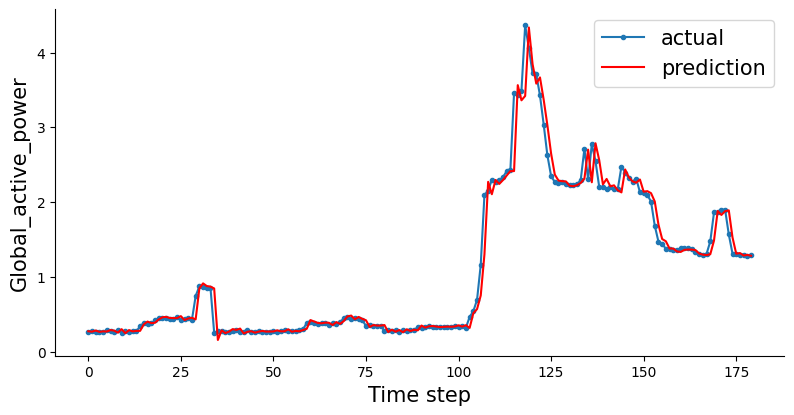

In [113]:
# Сравните фактические данные с прогнозируемыми за последние 180 минут

aa = [x for x in range(180)]
plt.figure(figsize=(8, 4))
plt.plot(aa, y_test[0][:180], marker=".", label="actual")
plt.plot(aa, test_predict[:, 0][:180], "r", label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel("Global_active_power", size=15)
plt.xlabel("Time step", size=15)
plt.legend(fontsize=15)
plt.show()